In [1]:
import sys
sys.path.insert(0, '/home/jianx/search-exposure/forward_ranker/')
from train import train
from load_data import load
import torch
import csv
from test import test
from test import test_loader
import random
from train import generate_sparse
from torch import optim

In [2]:
num_epochs = 2
epoch_size = 2
batch_size = 10
learning_rate = 0.01
embed_size = 64

print("Num of epochs:", num_epochs)
print("Epoch size:", epoch_size)
print("Batch size:", batch_size)
print("Learning rate:", learning_rate)
print("Embedding size:", embed_size)
rank = 10
test_batch =43
MODEL_PATH = "/home/jianx/data/results/"

Num of epochs: 2
Epoch size: 2
Batch size: 10
Learning rate: 0.01
Embedding size: 64


In [3]:
print("Loading data")
pos_neg_dict, query_dict, passage_dict, top_dict, rating_dict, query_test_dict = load()
print("Data successfully loaded.")
print("Positive Negative Pair dict size: " + str(len(pos_neg_dict)))
print("Num of queries: " + str(len(query_dict)))
print("Num of passages: " + str(len(passage_dict)))

Loading data
Data successfully loaded.
Positive Negative Pair dict size: 400782
Num of queries: 808731
Num of passages: 8841823


In [6]:
model_path = "/home/jianx/data/results/"
CURRENT_DEVICE = torch.device("cuda:1")
num_epochs = 100
epoch_size = 100
batch_size = 100
learning_rate = 0.001
embed_size = 256
from network import DSSM
net = DSSM(embed_size=embed_size, device=CURRENT_DEVICE).to(CURRENT_DEVICE)

arg_str = str(num_epochs) + "_" + str(epoch_size) + "_" + str(batch_size) + "_" + str(learning_rate) + "_" + str(
    embed_size)
unique_path = model_path + arg_str + ".model"
output_path = model_path + arg_str + ".csv"
for ep_idx in range(num_epochs):
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    train_loss = train(net, epoch_size, batch_size, optimizer, CURRENT_DEVICE, pos_neg_dict,
                       query_dict, passage_dict)
    avg_ndcg, avg_prec, avg_rr = test(net, CURRENT_DEVICE, test_batch, top_dict, query_test_dict, passage_dict,
                                      rating_dict, rank)
    print("Epoch:{}, loss:{}, NDCG:{}, P:{}, RR:{}".format(ep_idx, train_loss, avg_ndcg, avg_prec, avg_rr))
    with open(output_path, mode='a+') as output:
        output_writer = csv.writer(output)
        output_writer.writerow([ep_idx, train_loss, avg_ndcg, avg_prec, avg_rr])
    torch.save(net, unique_path)

[(3057274, 0.9069713950157166), (3057273, 0.9044382572174072), (4107820, 0.9036895632743835), (8639635, 0.9029430747032166), (4498420, 0.8897228837013245), (3344828, 0.8896449208259583), (69099, 0.8832495808601379), (6299991, 0.878145158290863), (8828338, 0.8766970634460449), (3110411, 0.8756996393203735), (6990339, 0.8724178075790405), (13492, 0.8711676001548767), (6299988, 0.8711671233177185), (6439448, 0.8687621355056763), (1316336, 0.8672751784324646), (7073780, 0.8663621544837952), (3174840, 0.8663207292556763), (6903550, 0.86583012342453), (8252758, 0.8619726300239563), (2085398, 0.8602481484413147), (7139368, 0.8598122596740723), (6231569, 0.8591523170471191), (1766535, 0.8591523170471191), (3947233, 0.8586560487747192), (7554450, 0.8564550280570984), (8828334, 0.8557252883911133), (5239348, 0.8550208806991577), (1696466, 0.8543663620948792), (788020, 0.8534464240074158), (8820893, 0.8529996871948242), (4119829, 0.8527772426605225), (3947238, 0.8487498164176941), (5346759, 0.846

In [55]:
CURRENT_DEVICE = torch.device("cuda:1")
loaded_net = torch.load("/home/jianx/data/results/300_1500_100_0.01_256.model").to(CURRENT_DEVICE)

In [56]:
result_dict = test_loader(loaded_net, CURRENT_DEVICE, test_batch, top_dict, query_test_dict, passage_dict, rating_dict)
qids = list(result_dict.keys())

[(6967840, 0.9703289866447449), (6030824, 0.9515329003334045), (2138895, 0.9465405344963074), (3145535, 0.929396390914917), (1429447, 0.9197744727134705), (2914522, 0.9071685671806335), (4995086, 0.9040905237197876), (6873899, 0.9023785591125488), (3145538, 0.8940309882164001), (3145540, 0.8835902810096741), (4995078, 0.8812158107757568), (8339241, 0.8801884055137634), (3942890, 0.8797808289527893), (2681045, 0.8762857913970947), (2504350, 0.8746423125267029), (897633, 0.8696666955947876), (8289712, 0.8681561350822449), (8528201, 0.8642295002937317), (4404309, 0.8610590696334839), (4373035, 0.857689619064331), (1551284, 0.8549997806549072), (8503364, 0.8543818593025208), (4759705, 0.854280948638916), (6970076, 0.8428561091423035), (6295746, 0.8394182324409485), (1756426, 0.8272055387496948), (2681048, 0.8223010301589966), (6527160, 0.8184680938720703), (8135452, 0.8178342580795288), (3686024, 0.8166230916976929), (4234915, 0.8157975673675537), (1688775, 0.8126513361930847), (8710743, 0

In [57]:
with open('/home/jianx/data/trec_eval/300_1500_100_0.01_256.teIn', 'w+') as f:
    for qid in qids:
        for rank, item in enumerate(sorted(result_dict[qid].items(), key=lambda x: (x[1], [-1, 1][random.randrange(2)]), reverse=True)):
            f.write("{}\tQ0\t{}\t{}\t{}\trun-id\n".format(qid, item[0],rank+1, item[1]))

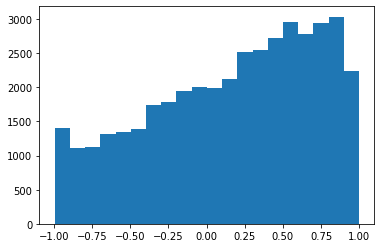

0.020905413966180984
0.01698260318697919


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
all_scores = []
num_95 = 0
num_neg95 = 0
for i in qids:
    for item in sorted(result_dict[i].items(), key=lambda x: (x[1], [-1, 1][random.randrange(2)]), reverse=True):
        all_scores.append(item[1])
        if item[1] > 0.95:
            num_95+=1
        if item[1] < -0.95:
            num_neg95 += 1
plt.hist(all_scores, bins=20)
plt.show()
print(num_95/len(all_scores))
print(num_neg95/len(all_scores))

In [18]:
top_pids = []
qid = 1
for i in range(10):
    top_pids.append(sorted(result_dict[qids[qid]].items(), key=lambda x: (x[1], [-1, 1][random.randrange(2)]), reverse=True)[i][0])
print(top_pids)

[3551618, 2009615, 4408691, 1863056, 83456, 555080, 6105784, 6895496, 3551621, 4827423]


(array([304., 191.,  60.,  51.,  47.,  33.,  37.,  44.,  59., 174.]),
 array([-9.97311234e-01, -7.97699982e-01, -5.98088729e-01, -3.98477477e-01,
        -1.98866224e-01,  7.45028257e-04,  2.00356281e-01,  3.99967533e-01,
         5.99578786e-01,  7.99190038e-01,  9.98801291e-01]),
 <a list of 10 Patch objects>)

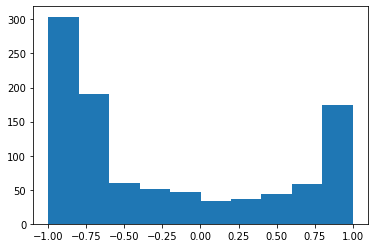

In [19]:
result0 = pd.DataFrame.from_dict(sorted(result_dict[qids[11]].items(), key=lambda x: (x[1], [-1, 1][random.randrange(2)]), reverse=True))
plt.hist(result0[1])

In [48]:
import math
def get_ndcg_precision_rr(true_dict, test_dict, rank):
    sorted_result = sorted(test_dict.items(), key=lambda x: (x[1], [-1,1][random.randrange(2)]), reverse=True)
    original_rank = rank
    rank = min(rank, len(sorted_result))
    cumulative_gain = 0
    num_positive = 0
    rr = float("NaN")
    for i in range(len(sorted_result)):
        pid = sorted_result[i][0]
        if pid in true_dict:
            rr = 1 / (i + 1)
            break
    for i in range(rank):
        pid = sorted_result[i][0]
        if pid in true_dict:
            num_positive += 1
    sorted_result = sorted(test_dict.items(), key=lambda x: x[1], reverse=True)
    for i in range(rank):
        pid = sorted_result[i][0]
        relevance = 0
        if pid in true_dict:
            relevance = true_dict[pid]
        discounted_gain = relevance / math.log2(2 + i)
        cumulative_gain += discounted_gain
    sorted_ideal = sorted(true_dict.items(), key=lambda x: x[1], reverse=True)
    ideal_gain = 0
    for i in range(rank):
        relevance = 0
        if i < len(sorted_ideal):
            relevance = sorted_ideal[i][1]
        discounted_gain = relevance / math.log2(2 + i)
        ideal_gain += discounted_gain
    ndcg = 0
    if ideal_gain != 0:
         ndcg = cumulative_gain / ideal_gain
    return ndcg, num_positive / original_rank, rr

In [49]:
import numpy as np
result_ndcg = []
result_prec = []
result_rr = []
for qid in qids:
    if len(result_dict[qid]) < 10:
        print(qid)
    ndcg, prec, rr = get_ndcg_precision_rr(rating_dict[qid], result_dict[qid], 10)
    result_ndcg.append(ndcg)
    result_prec.append(prec)
    result_rr.append(rr)

avg_ndcg = np.nanmean(result_ndcg)
avg_prec = np.nanmean(result_prec)
avg_rr = np.nanmean(result_rr)
print(avg_ndcg,avg_prec,avg_rr)

855410
0.12105259069123926 0.15348837209302324 0.2882534527233264


In [58]:
print(rating_dict[qid].values())

dict_values([2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 3, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 3, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 3, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [53]:
from test import test
test(loaded_net, CURRENT_DEVICE, test_batch, top_dict, query_test_dict, passage_dict, rating_dict, rank)

[(59539, 0.9993202090263367), (2715743, 0.9992823004722595), (2478116, 0.9992520213127136), (5974242, 0.999213457107544), (4870121, 0.9991028308868408), (4117670, 0.9990413188934326), (3559148, 0.9990376234054565), (8419980, 0.9988998174667358), (2379409, 0.9988841414451599), (485254, 0.9987636208534241), (2110023, 0.9987540245056152), (1083174, 0.998534619808197), (2641960, 0.9984148740768433), (3564771, 0.9983661770820618), (738067, 0.9980972409248352), (5829204, 0.9980781674385071), (2850030, 0.9980266094207764), (3672742, 0.9974265098571777), (2609437, 0.9970454573631287), (3964715, 0.9969422817230225), (338923, 0.9968646168708801), (3098356, 0.9965070486068726), (6404781, 0.9961471557617188), (4726837, 0.9959345459938049), (4824830, 0.9959103465080261), (1070309, 0.9957007765769958), (1294091, 0.9951753616333008), (8497972, 0.9949520826339722), (4194875, 0.9947736263275146), (5062705, 0.994552731513977), (2810198, 0.9940405488014221), (2259571, 0.9931426644325256), (1931459, 0.993

(0.36934209449012356, 0.06858020811509183, 1.0)

In [43]:
def get_ndcg_precision_rr(true_dict, test_dict, rank):
    sorted_result = sorted(test_dict.items(), key=lambda x: (x[1], [-1,1][random.randrange(2)]), reverse=True)
    original_rank = rank
    rank = min(rank, len(sorted_result))
    cumulative_gain = 0
    ideal_dict = true_dict
    num_positive = 0
    rr = float("NaN")
    for i in range(len(sorted_result)):
        pid = sorted_result[i][0]
        if pid in true_dict:
            rr = 1 / (i + 1)
            break
    for i in range(rank):
        pid = sorted_result[i][0]
        if pid in true_dict:
            num_positive += 1
    sorted_result = sorted(test_dict.items(), key=lambda x: x[1], reverse=True)
    for i in range(rank):
        pid = sorted_result[i][0]
        relevance = 0
        if pid in true_dict:
            relevance = true_dict[pid]
        ideal_dict[pid] = relevance
        discounted_gain = relevance / math.log2(2 + i)
        cumulative_gain += discounted_gain
    sorted_ideal = sorted(ideal_dict.items(), key=lambda x: x[1], reverse=True)
    ideal_gain = 0
    for i in range(rank):
        relevance = sorted_ideal[i][1]
        discounted_gain = relevance / math.log2(2 + i)
        ideal_gain += discounted_gain
    ndcg = 0
    if ideal_gain != 0:
         ndcg = cumulative_gain / ideal_gain
    return ndcg, num_positive / original_rank, rr
import numpy as np
result_ndcg = []
result_prec = []
result_rr = []
for qid in qids:
    if len(result_dict[qid]) < 10:
        print(qid)
    ndcg, prec, rr = get_ndcg_precision_rr(rating_dict[qid], result_dict[qid], 10)
    result_ndcg.append(ndcg)
    result_prec.append(prec)
    result_rr.append(rr)
print(result_ndcg)
avg_ndcg = np.nanmean(result_ndcg)
avg_prec = np.nanmean(result_prec)
avg_rr = np.nanmean(result_rr)
print(avg_ndcg,avg_prec,avg_rr)

855410
[0.0, 0.6749359875559982, 0.026899541414986676, 0.0, 0.06625422345438903, 0.0, 0.1731866333482261, 0.06625422345438903, 0.5779653265761806, 0.07435025380391322, 0.0, 0.0, 0.28682555242855845, 0.10673691490577927, 0.028381039213873662, 0.0, 0.0659734950602057, 0.04731272247541591, 0.08829915600403987, 0.0, 0.0, 0.06962520285192768, 0.0, 0.0, 0.8811991369160118, 0.32949427969625866, 0.0, 0.0, 0.0, 0.0, 0.02613275632622511, 0.0636207881989517, 0.14338108388728518, 0.3434612313521942, 0.0, 0.0, 0.06943122193677725, 0.121825078691301, 0.05091516310842829, 0.6497664480612815, 0.1162360614882298, 0.0, 0.08514311764162098]
0.12171178232214998 0.9883720930232558 1.0


In [30]:
test_qid = 1133167
test_pid = 6112590
test_q_embed = net(generate_sparse(query_test_dict[test_qid]).to(CURRENT_DEVICE)).detach()
test_p_embed = net(generate_sparse(passage_dict[test_pid]).to(CURRENT_DEVICE)).detach()
test_score = torch.cosine_similarity(test_q_embed.unsqueeze(0), test_p_embed.unsqueeze(0)).item()
print(test_score)
print(test_p_embed)

print(test_q_embed)

-0.8975946307182312
tensor([-3.0296e+03, -5.2848e+04,  2.3425e-02,  6.3025e-02, -1.0471e-01,
        -1.2495e+03,  2.3125e+04,  6.2536e-02,  1.3906e-01,  2.3375e+04,
        -2.5828e+04,  4.8552e+02, -4.4572e+03, -2.1202e+04, -2.2999e-02,
         9.1718e-02, -4.9721e+04, -4.0220e+03,  3.5009e-01, -2.2760e+04,
        -1.8646e+04,  1.6650e+03, -4.0550e+04, -2.2024e+04,  5.0473e+04,
        -4.8476e+04,  1.4154e+04, -1.0826e+03, -6.3183e+03,  1.4134e-01,
        -8.9433e+03,  3.2223e+04, -9.0528e+03,  5.4107e+04,  4.3253e+04,
        -1.0032e+04, -9.7527e+03, -4.7771e+04,  2.5884e+04, -7.8262e+03,
         2.0455e-01,  5.1378e+04,  9.3307e+03,  6.5136e+03,  1.5810e+04,
         1.3519e-02, -1.0916e+04, -9.4892e+02,  4.7940e+03,  8.1336e+03,
        -3.5506e+04,  5.5301e+04, -2.1024e+04, -7.8287e+03,  2.0133e+04,
         5.7350e+03,  4.4025e+04,  2.8542e-02,  2.8935e+04,  2.3223e+04,
        -4.4460e+04, -1.4056e+04,  4.0348e+04,  8.1690e+03, -2.3161e-02,
         9.8422e+03,  7.1057e+0